In [1]:
import math
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

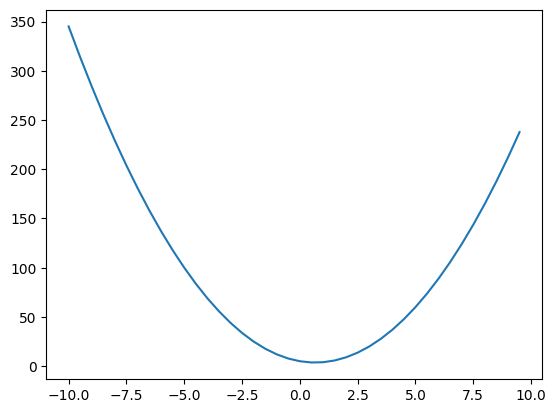

In [4]:
xs = np.arange(-10,10,0.5)
ys = f(xs)
plt.plot(xs,ys)
plt.show()

In [5]:
h = 0.000001
x = 2.5
(f(x+h) - f(x))/h

11.000003002692438

In [6]:
h = 0.000001

a = 2.0
b = -3.0
c = 10.0
d = a*b + c

In [7]:
d1 = a*b+c
c +=h
d2 = a*b+c

(d2-d1)/h

0.9999999992515995

In [8]:
class Value:
    def __init__(self,data,children=(),op='',label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda:None

    def __repr__(self):
        return f"Values=(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad+=out.grad
            other.grad+=out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        # other = other if isinstance(other, Value) else Value(other)
        return self + (-other)

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        
        def _backward():
            self.grad+=out.grad*other.data
            other.grad+=out.grad*self.data
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out
        
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self,other):
        return self * other

    def __truediv__(self,other):
       return self * other**-1

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')

        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward = _backward
        return out

    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
#Build the connections as nodes and edges between different nodes.
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label= "{%s | data %.4f | grad %.4f}" %(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label= n._op)
            dot.edge(uid+n._op,uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

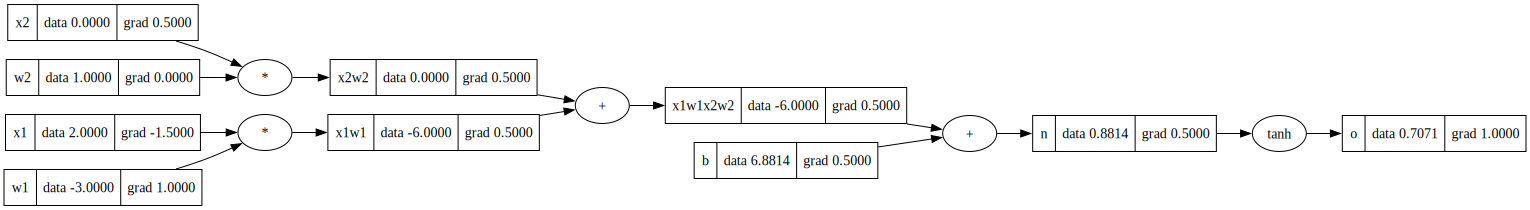

In [10]:
#Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#Bias of the neuron
b = Value(6.8813735870195432,label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)

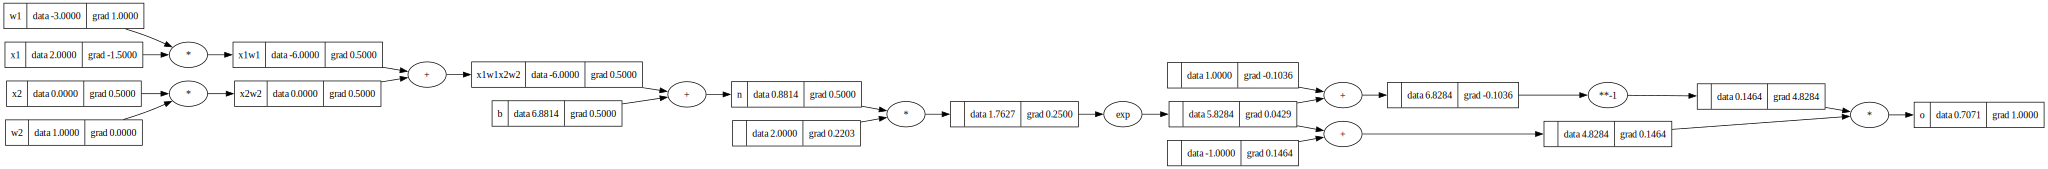

In [11]:
#Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#Weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#Bias of the neuron
b = Value(6.8813735870195432,label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'

#----------#
e = (2*n).exp()
o = (e-1)/(e+1); o.label='o'
# o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)

In [12]:
import torch
import random


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/jacksonsunny/miniconda3/envs/neuralnets/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/jacksonsunny/miniconda3/envs/neuralnets/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/jacksonsunny/miniconda3/envs/neuralnets/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/jacksonsunny/miniconda3/envs/neuralnets/lib/python3.10/site-pa

In [13]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        assert len(self.w) == len(x) , "Length should the same"
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)  
        out = act.tanh()
        return out

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out)==1 else out

class MLP:
    def __init__(self,nin, nout):
        nout = nout if isinstance(nout,list) else [nout]
        sz = [nin] + nout
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nout))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Values=(data=0.9076569172485746)

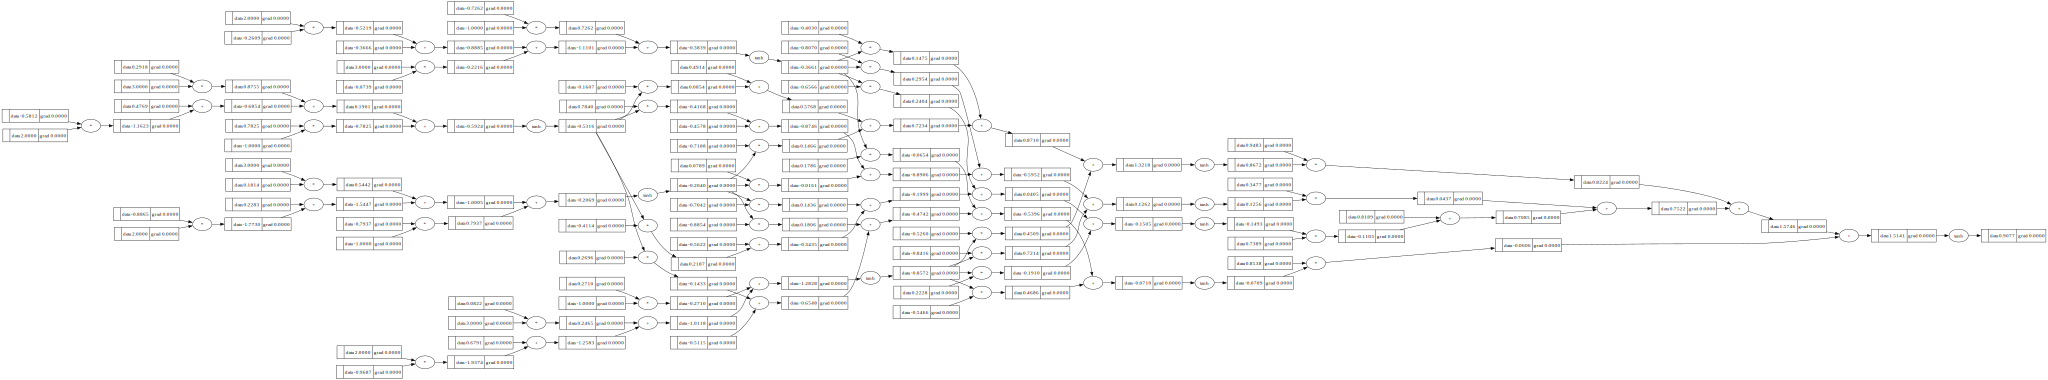

In [14]:
draw_dot(n(x))

In [15]:
# Sample data 
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0]
y_pred = [n(x) for x in xs]

In [16]:
y_pred

[Values=(data=0.9076569172485746),
 Values=(data=0.9923670734850307),
 Values=(data=0.9397524311188001),
 Values=(data=0.21297048007179886)]

In [17]:
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,y_pred))

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [ ]:
loss

In [ ]:
loss.backward()
draw_dot(loss)

In [ ]:
list(zip(ys,y_pred))[0][0] - list(zip(ys,y_pred))[0][1] 